# ISIC Data Preparation & Balancing
#### Here we will reformat the labels, perform splits and perform augmentation.
Start by downloading the ISIC 2019 training data and ground truth labels (https://challenge2019.isic-archive.com/).
Extract them and update the filepaths in the code below. Lines sensitive to filepath are marked with arrows and asterisks.

In [ ]:
# In the ISIC 2019 ground truth file, diagnoses ('dx') are one-hot encoded. This doesn't play nice with
# Pytorch so we'll need to convert these into a single column with strings representing each class

import pandas as pd
import os

# ***** define total number of unique classes in the dataset *****
n_class = 8

# ***** Setup your working dir & csv file here *****
os.chdir('C:\\Users\\Robin\\Desktop\\2019')
meta_df = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')

# Rename 'image' column to 'image_id' (to match code below)
meta_df.columns.values[0] = 'image_id'

# Slice up the metadata dataframe by diagnosis; could do a loop but lazy :/
akiec_df = meta_df[meta_df['AK'] == 1]
bcc_df = meta_df[meta_df['BCC'] == 1]
bkl_df = meta_df[meta_df['BKL'] == 1]
df_df = meta_df[meta_df['DF'] == 1]
mel_df = meta_df[meta_df['MEL'] == 1]
nv_df = meta_df[meta_df['NV'] == 1]
scc_df = meta_df[meta_df['SCC'] == 1]
vasc_df = meta_df[meta_df['VASC'] == 1]

frames_list = [akiec_df,bcc_df,bkl_df,df_df,mel_df,nv_df,scc_df,vasc_df]
dx_list = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'scc', 'vasc']

# Assign appropriate value for 'dx' column for each slice and then concat all back to single df
for i in range(len(frames_list)):
    frames_list[i]['dx'] = dx_list[i]

meta_df = pd.concat(frames_list)

#add 'cancer' column; 'cx' = pre-cancer + cancer; 'bn' = benign lesions
cx_labels = ['akiec', 'bcc', 'mel', 'scc']
meta_df['cancer'] = ['cx' if dx in cx_labels else 'bn' for dx in meta_df['dx']]

In [11]:
# define Pytorch Dataset structure
# official documentation at https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# Basically, this is just a collection of functions that pulls up an image file iteratively
# For example if i=55, this will pull the filename of the image from the 55th row of the metadata file
# Overall, prevents the entire dataset from having to be read into memory

import torch
from torchvision.transforms import transforms, ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
from PIL import Image

class ImageDataset(Dataset):
  def __init__(self, datadir, dataframe, transforms = None):
    super().__init__()
    self.datadir = str(datadir) #assigns user inputed data dir
    self.df = dataframe #assigns metadata df to class object 
    self.transform = transforms #assigns desired transforms to class object

  def __len__(self):
    return(self.df.shape[0]) #overrides base len() func call to return number of images

  def labels(self):
    labels = self.df['dx'].unique() #returns string label for each 'dx' class
    labels = sorted(labels)
    return 
    
  def description(self):
      return self.df['dx'].value_counts() #returns number of images for each 'dx' class

  def __getitem__(self, idx):
    labels = dict(zip(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'scc', 'vasc'], range(n_class))) #assigns dx to integer coded value to be used as index later
    row = self.df.iloc[idx] #selects nth row from metadata
    image = row['image_id'] #selects image filename from selected row
    label_one_hot = np.zeros(n_class).astype(int) #vector of n_class zeros
    label_one_hot[labels[row['dx']]] = 1 #inserts value of 1 at index corresponding to above integer coded value
    image = Image.open((self.datadir + image + '.jpg'))

    if self.transform:
      image = self.transform(image)

    return image, torch.tensor(label_one_hot) #call image data from appropriate tensor index

In [12]:
# dictionary for human-readable labels for plotting
dx_dict = {
'akiec': 'Actinic Keratosis',
'bcc': 'Basal Cell Carcinoma',
'bkl': 'Benign Keratosis',
'df': 'Dermatofibroma',
'mel': 'Melanoma',
'nv': 'Nevus (Mole)',
'scc' : 'Squamous Cell Carcinoma',
'vasc': 'Vascular'
}

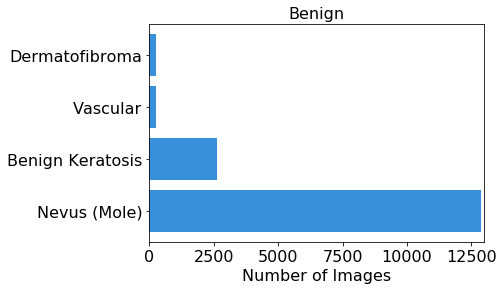

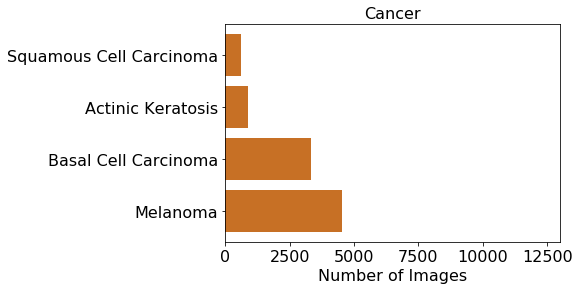

In [13]:
# Group images into either benign and cancer; this is only for plotting purposes
bn_all_df = meta_df[meta_df['cancer'] == 'bn']
cx_all_df = meta_df[meta_df['cancer'] == 'cx']

bn_preaug = bn_train = ImageDataset('all_imgs', bn_all_df) # ***** first arg needs to refect the filepath of where images are *****
cx_preaug = bn_train = ImageDataset('all_imgs', cx_all_df) # ***** first arg needs to refect the filepath of where images are *****

# Plot number of images per class
import matplotlib
desc = bn_preaug.description()
desc= dict(desc)
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)
y_labs_bn = [dx_dict[i] for i in list(desc.keys())]
plt.barh(y_labs_bn, desc.values(), color='#388FDA')
plt.xlabel('Number of Images', size=16)
plt.title('Benign', size=16)
plt.xlim((0,13000))
#plt.savefig('raw_bn_classrep.png', dpi=150, bbox_inches = "tight")
plt.show()

desc = cx_preaug.description()
desc= dict(desc)
matplotlib.rc('xtick', labelsize=16)     
matplotlib.rc('ytick', labelsize=16)
y_labs_cx = [dx_dict[i] for i in list(desc.keys())]
plt.barh(y_labs_cx, desc.values(), color='#C77025')
plt.xlabel('Number of Images', size=16)
plt.title('Cancer', size=16)
plt.xlim((0,13000))
#plt.savefig('raw_cx_classrep.png', dpi=150, bbox_inches = "tight")
plt.show()

In [14]:
# Shuffle rows for each subset dataframe; this is happening on the original 8-way split
for i in range(len(frames_list)):
  frames_list[i] = frames_list[i].sample(frac=1).reset_index(drop=True)
  
# Undersample 'nv' class based on all 'mel' images; will also unify total images numbers between benign and cancer splits
n_max = int(mel_df.shape[0])
frames_list[5] = frames_list[5][0:n_max]

In [16]:
# Re-assemble shuffled 8-way splits into list of benign and cancer dfs
bn_frames = [frames_list[2], frames_list[3], frames_list[5], frames_list[7]]
cx_frames = [frames_list[0], frames_list[1], frames_list[4], frames_list[6]]

# Define function to select 80% of images from each class split for train
# and remaining 20% for validation. Creates training/validation metadata
# dfs and updates as each split is processed
def build_meta(frames_list):
  training_meta = pd.DataFrame()
  validation_meta = pd.DataFrame()
  for i in range(len(frames_list)):
    n_train = int(0.8 * len(frames_list[i]))
    train = frames_list[i][0:n_train]
    valid = frames_list[i][n_train:-1]
    training_meta = training_meta.append(train, ignore_index=True)
    validation_meta = validation_meta.append(valid, ignore_index=True)
  return training_meta, validation_meta

# Execute
bn_training_meta, bn_validation_meta = build_meta(bn_frames)
cx_training_meta, cx_validation_meta = build_meta(cx_frames)

In [17]:
# Define image transforms
# Convert each image into tensor; normalize values are recommended mean/std based on ImageNet
transfx = transforms.Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 

# Initialize a Pytorch Dataset for each set of images listed in our four meta dfs
bn_train = ImageDataset('all_imgs', bn_training_meta, transfx) # ***** first arg needs to refect the filepath of where images are *****
bn_valid = ImageDataset('all_imgs', bn_validation_meta, transfx) # ***** first arg needs to refect the filepath of where images are *****
cx_train = ImageDataset('all_imgs', cx_training_meta, transfx) # ***** first arg needs to refect the filepath of where images are *****# ***** first arg needs to refect the filepath of where images are *****
cx_valid = ImageDataset('all_imgs', cx_validation_meta, transfx) # ***** first arg needs to refect the filepath of where images are *****

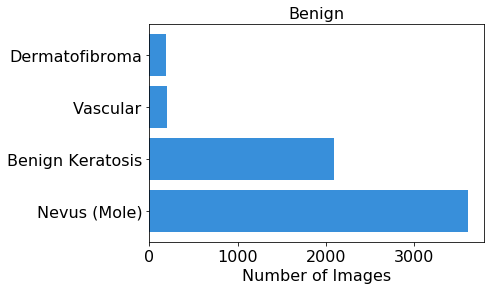

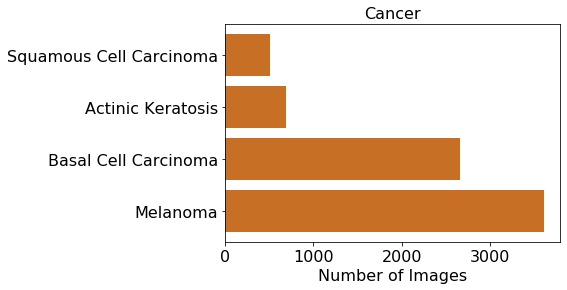

In [19]:
# Plot number of images per class in training data after undersampling the
# most abundant dx "nv" and random selection of 80% of each
desc = bn_train.description()
desc= dict(desc)
matplotlib.rc('xtick', labelsize=16)     
matplotlib.rc('ytick', labelsize=16)
plt.barh(y_labs_bn, desc.values(), color='#388FDA')
plt.xlabel('Number of Images', size=16)
plt.title('Benign', size=16)
#plt.savefig('pre_aug_bn_classrep.png', dpi=150, bbox_inches = "tight")
plt.show()

desc = cx_train.description()
desc= dict(desc)
matplotlib.rc('xtick', labelsize=16)     
matplotlib.rc('ytick', labelsize=16)
plt.barh(y_labs_cx, desc.values(), color='#C77025')
plt.xlabel('Number of Images', size=16)
plt.title('Cancer', size=16)
#plt.savefig('pre_aug_cx_classrep.png', dpi=150, bbox_inches = "tight")
plt.show()

#### Much better now in regards to the 'Nevus' class, but still need to address the sparseness of classes like 'Vascular'. We'll do partial image augmentation below to come up with more training data for these classes.

In [20]:
# Define a function to perform over/up-sampling for sparse classes
# using partial image augmentation. By augmenting the original images
# by shifting or rotating, we can created a pseudo-expanded dataset
# for classes like "vasc" where there are only hundreds of photos

def go_aug(ds_train, training_meta, multiplier):
  #updated function calls to work with TensorFlow 2
  import tensorflow as tf 
  from tqdm import tqdm_notebook as tqdm #this is just a juypter notebook progress bar; used below

  #Create image augmentor for training data and set limits/ranges for augmentations
  aug_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 15,
                          width_shift_range = 0.1,
                          height_shift_range = 0.1, 
                          shear_range = 0.15,
                          zoom_range = 0.1,
                          channel_shift_range = 15,
                          horizontal_flip = True) 

  desc = ds_train.description() #print number of images per dx; use below to define number of augmentations needed per dx to balance
  target_n = int(max(desc)*multiplier) #set target number of images to that of most abundant class

  for key in desc.keys(): #key here refers to each dx label
    print(key, desc[key])
    ratio = int(target_n / desc[key]) #set ratio relative to most abuandant dx
    print('Need around', ratio, 'augmentations per image to balance to', target_n)
    all_images = training_meta[training_meta['dx'] == key]['image_id'].values #get image ids for current dx
    if(len(training_meta[training_meta['dx'] == key]) >= target_n): #skip rest of code of already maxed out
      continue
    checkstate = True
    #iterate over all images, augment, save new images to disc, and insert row into metadata
    for curr_image in tqdm(all_images):   #nice little progress bar with tqdm
      if(len(training_meta[training_meta['dx'] == key]) >= target_n): #halt when target reached
        if checkstate:
          print(key, 'data points = ', len(training_meta[training_meta['dx'] == key]), ' -- skipping more augmentations...')
          checkstate = False
        continue
      basedir = 'all_imgs\\' # <------------ ***** this needs to be changed to reflect current working env!! *****
      image_path =  basedir + curr_image + '.jpg'
      image = tf.keras.preprocessing.image.load_img(image_path)

      image = np.expand_dims(tf.keras.preprocessing.image.img_to_array(image), axis= 0)
      generated = aug_gen.flow(image) #assign batches of augmented images
      row = training_meta[training_meta['image_id'] == curr_image]
      dict_for_df= {'image_id':row.image_id.values[0], 'dx':row.dx.values[0]} #for correctly saving filenames and updating meta df
      for i in range(int(ratio)):
        aug_image = next(generated).astype(np.uint8) #iterate thru batches of augmented images
        image_name = dict_for_df['image_id'].split('_aug_', 1)[0]
        image_name = image_name + '_aug_' + str(i)
        dict_for_df['image_id'] = image_name
        training_meta = training_meta.append(dict_for_df, ignore_index=True)
        plt.imsave(basedir + image_name + '.jpg', aug_image[0]) #save augmented images to disc with suffix
  return training_meta

In [ ]:
# Execute augmentation on training data for benign classes; get updated meta file
bn_training_meta_aug = go_aug(bn_train, bn_training_meta, 1)

In [ ]:
# Execute augmentation on training data for cancer classes; get updated meta file
cx_training_meta_aug = go_aug(cx_train, cx_training_meta, 1)

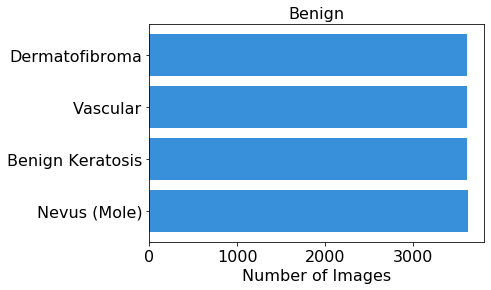

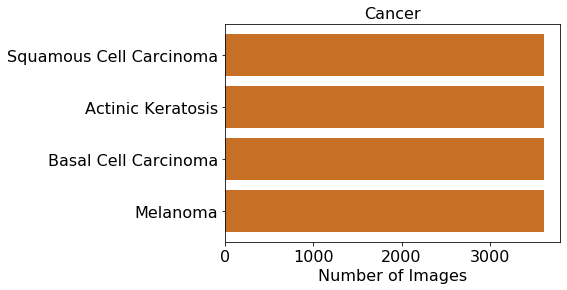

In [38]:
# Plot number of images per class in training data after augmentation 
ds_train = ImageDataset('/content/data/all_imgs/', bn_training_meta_aug, transfx) # ***** first arg needs to refect the filepath of where images are *****
desc = ds_train.description()
desc= dict(desc)
matplotlib.rc('xtick', labelsize=16)     
matplotlib.rc('ytick', labelsize=16)
plt.barh(y_labs_bn, desc.values(), color='#388FDA')
plt.xlabel('Number of Images', size=16)
plt.title('Benign', size=16)
#plt.savefig('post_aug_bn_classrep.png', dpi=150, bbox_inches = "tight")
plt.show()

ds_train = ImageDataset('/content/data/all_imgs/', cx_training_meta_aug, transfx)
desc = ds_train.description()
desc= dict(desc)
matplotlib.rc('xtick', labelsize=16)     
matplotlib.rc('ytick', labelsize=16)
plt.barh(y_labs_cx, desc.values(), color='#C77025')
plt.xlabel('Number of Images', size=16)
plt.title('Cancer', size=16)
#plt.savefig('post_aug_cx_classrep.png', dpi=150, bbox_inches = "tight")
plt.show()

#### So now we have about 3,700 images per class for training. It's not perfect, but overall increases the chances our model will perform without heavy biases.

In [ ]:
# Combine bn/cx meta dfs and save to disc
training_meta = bn_training_meta_aug.append(cx_training_meta_aug)
validation_meta = bn_validation_meta.append(cx_validation_meta)

training_meta.to_csv("training_metadata.csv")
validation_meta.to_csv("validation_metadata.csv")

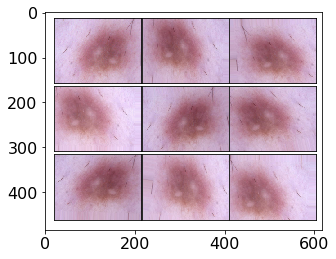

In [24]:
# Below is an example of an image that was augmented a total of 8 times
# The original image (top left) was shifted/sheared/rotated/flipped to
# create 8 pseudo-unique images. In practice this improves model accuracy
# helps prevent overfitting, and bias towards classes with greater numbers
# of unique images

from PIL import Image
example = Image.open('example_augmentations.png')
plt.imshow(example)